In [1]:
%reload_ext tutorial.tests.testsuite

# Parallelism and concurrency in Python

## Introduction
There are many cases where we could execute multiple tasks in parallel or switch between tasks while we wait for some time consuming task to be completed.
You can just think of examples from daily life to see why: 

- While your soup cooks on the stove, you start washing your dishes
- You check the news while drinking your morning coffee
- You work on your python course exercises while attending a video call

Indeed, the language of computing is so engrained in many of us that today we refer to these sort of behaviors as *multitasking*, an expression borrowed from computer science.

Because in computer science we like to be precise, let us define these terms better.

## Parallelism Vs. concurrency

### Parallelism
When we have two or more tasks *running and progressing simultaneously*, we can talk about **parallelism**. 
Think for example of the situation of paying at the supermarket where there are multiple lines: more than one customer can pay their purchases at the same time

### Concurrency
When two or more tasks run in overlapping time periods (but **not necessarily simultaneously**) instead of sequentially, we say that their execution is **concurrent**.
This is the typical human multitasking, where we work on multiple tasks in a time period, but we must switch between them to be able to perform them correctly.
For example, we sit in a meeting, listen passively while working on our python program and stop working on our code to answer a question directed to us.



The image below can help you understanding the difference between concurrent and parallel work.
<figure>
  <img
  src="../../images/concurrency_vs_parallelism.jpg"
  height="400px"
  alt="The beautiful MDN logo.">
  <figcaption>A simple time diagram illustrating the difference between parallelism and concurrency (source: https://openclassrooms.com/en/courses/5684021-scale-up-your-code-with-java-concurrency/5684028-identify-the-advantages-of-concurrency-and-parallelism)</figcaption>
</figure>


### Quiz: parallel or not
For each of these real-life examples, determine if the tasks are executed in parallel or not

- One cashier serves two lines of people in a store
- A swimming pool offers multiple shower stalls 
- Multiple people take turns drinking from a cup


## Parallelism in python: pre-emptive multitasking
By default, in python tasks do not run in parallel. Consider this example:



In [2]:
from datetime import datetime as dt
from time import sleep

def task(name: str):
    """
    This function defines a fictional task that takes one second
    to complete and prints when it started and finished.
    """
    print(f"{name} started at {dt.now()}")
    sleep(1)
    print(f"{name} finished at {dt.now()}")



def two_tasks():
    task("First task")
    task("Second task")


two_tasks()


First task started at 2023-10-31 09:09:00.511459
First task finished at 2023-10-31 09:09:01.511561
Second task started at 2023-10-31 09:09:01.511673
Second task finished at 2023-10-31 09:09:02.511766


We see that the first task to be started (`First task`) finished before the second one could start. 
This is the sequential  computational model we are used to when we first learn programming. 
However, in python we can introduce **parallelism** by using the [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) module. 

Using this module, we can execute code in different operating system **processes**. 
A process is a representation of a task, with all the code, memory and resources (files, network connections, etc.) needed to run it. 
In most cases, processes are managed by the operating system, which takes care of scheduling what process should currently run and takes care that no process can run forever and regularly yields computing resources to other processes.
This approach is called **preemptive multitasking** and is the standard way of running multiple processes in modern desktop and server operating systems. 

When working on a multi-core or multi-CPU system, it is possible to leverage multitasking to run your computations in parallel. 
We will see how in the following sections.

### High-level interface: Process pools

Let's rewrite our example from before using [`multiprocessing.Pool`](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool) which executes jobs on a pool of shared processes.  


In [5]:
from datetime import datetime as dt
from time import sleep
from multiprocessing import Pool

def task(name: str):
    """
    This function defines a fictional task that takes one second
    to complete and prints when it started and finished.
    """
    print(f"{name} started at {dt.now()}")
    sleep(1)
    print(f"{name} finished at {dt.now()}")



def two_tasks():
    with Pool(3) as p:
        p.map(task, ["First task", "Second task"])


for i in range(10):
    two_tasks()

Second task started at 2023-10-31 09:17:18.444387First task started at 2023-10-31 09:17:18.444386

First task finished at 2023-10-31 09:17:19.446255Second task finished at 2023-10-31 09:17:19.446431

First task started at 2023-10-31 09:17:19.469125Second task started at 2023-10-31 09:17:19.469224

Second task finished at 2023-10-31 09:17:20.473578First task finished at 2023-10-31 09:17:20.473757

First task started at 2023-10-31 09:17:20.499679Second task started at 2023-10-31 09:17:20.499744

First task finished at 2023-10-31 09:17:21.504205Second task finished at 2023-10-31 09:17:21.504349

Second task started at 2023-10-31 09:17:21.531218First task started at 2023-10-31 09:17:21.531187

Second task finished at 2023-10-31 09:17:22.535944First task finished at 2023-10-31 09:17:22.536560

Second task started at 2023-10-31 09:17:22.559639First task started at 2023-10-31 09:17:22.559555

Second task finished at 2023-10-31 09:17:23.564162First task finished at 2023-10-31 09:17:23.565073



We use `Pool` as a [context manager](https://book.pythontips.com/en/latest/context_managers.html) and use the `map` method of the pool object to call the function `task` with a list of arguments. 
Internally, this will create and run a separate process for each value in the list.

As you can see from the console output, the two task not only run simultaneously (**concurrently**) but also in parallel. 
This output highlights quite well one problem with concurrent computations: the order of completion is **non-deterministic**. 
We cannot know a priori which process will be started first and which process will complete first. 
If the order of the results is important, you need to make sure to send and return some sort of identifier with each job, so that you can reconstruct the right order.

However, if we use `map`, it takes care of managing the order of tasks automatically:

In [13]:
from datetime import datetime as dt
from time import sleep
from multiprocessing import Pool

def increment(number: int) -> int:
    """
    This function increments the number by 1.
    """
    name = "Process " + str(number)
    print(f"{name} started at {dt.now()}")
    result = number + 1
    print(f"{name} finished at {dt.now()}")
    return result



def two_tasks():
    with Pool(3) as p:
        res = p.map(increment, range(10))
    print(res)



two_tasks()

Process 2 started at 2023-10-31 09:38:22.802498Process 1 started at 2023-10-31 09:38:22.802352Process 0 started at 2023-10-31 09:38:22.802282


Process 1 finished at 2023-10-31 09:38:22.804046Process 0 finished at 2023-10-31 09:38:22.804153Process 2 finished at 2023-10-31 09:38:22.804051


Process 3 started at 2023-10-31 09:38:22.804730Process 4 started at 2023-10-31 09:38:22.804826Process 5 started at 2023-10-31 09:38:22.805063


Process 4 finished at 2023-10-31 09:38:22.805455Process 5 finished at 2023-10-31 09:38:22.805627
Process 3 finished at 2023-10-31 09:38:22.805599Process 6 started at 2023-10-31 09:38:22.805979


Process 6 finished at 2023-10-31 09:38:22.806393Process 8 started at 2023-10-31 09:38:22.806500Process 7 started at 2023-10-31 09:38:22.806376
Process 8 finished at 2023-10-31 09:38:22.806961


Process 9 started at 2023-10-31 09:38:22.807409Process 7 finished at 2023-10-31 09:38:22.807244

Process 9 finished at 2023-10-31 09:38:22.807992
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10

### Low-level interface: Process, run, join and deadlocks

In some situations, we want more control over the execution of multiple processes. 
In that case, you can directly create processes using the [`Process`](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process) object. 
This offers several methods, primarily:
- `run()`: by default, it runs the callable object with the argument passed at the process creation time. 
    <div class="alert alert-block alert-warning">
        <h4><b>Warning</b></h4> The <code>run</code> method is <b>blocking</b> and will just execute the function in the current python process, blocking it until the execution finishes.
    </div>
- `start()`: it will start the computation defined by `run()` in a separate process.
- `join()`: this methods blocks the python interpreter process until the task defined by the owning `Process` finishes. 
     A process cannot join itself because this would cause a **deadlock**. This is a situation where there is a cycling dependency between some waiting resources. 
    In real life, imagine the situation of two friends waiting for each other to call before going out. `join` is useful when we want to make sure a given process finishes its job before continuing.

let's see an example on how to use this:

In [21]:
from multiprocessing import Process
from time import sleep
from datetime import datetime as dt

def log(message: str):
    """
    This function just prints a message.
    """
    print(f"{dt.now()}: {message}")

def friend(n: int, sleep_time: int = 1):
    """
    This function prints a friendly message.
    """
    log(f"Hello from process {n}")
    sleep(sleep_time)
    log(f"After sleeping, process {n} is done")

def waiting_friend(n: int, wait_for_friend: bool = True, sleep_time: int = 1):
    """
    This function waits for n friend processes to finish.
    """
    f = [Process(target=friend, args=(i, sleep_time)) for i in range(n)]
    for p in f:
        p.start()
        if wait_for_friend:
            p.join()
    log("Finished")



#Start without waiting for friend
waiting_friend(3, True, 10)


2023-11-06 10:07:27.002502: Hello from process 0
2023-11-06 10:07:37.005378: After sleeping, process 0 is done
2023-11-06 10:07:37.018859: Hello from process 1
2023-11-06 10:07:47.024417: After sleeping, process 1 is done
2023-11-06 10:07:47.035847: Hello from process 2
2023-11-06 10:07:57.040551: After sleeping, process 2 is done
2023-11-06 10:07:57.047580: Finished


You can see the effect of `join` in the output of `waiting_friend`. 
If we do not `join` on the child processes, they can finish in any order; we don't have any guarantee that they will finish at all. 
Indeed, you can see that `waiting_friends` prints "finished" before any of the child processes wakes up from sleep.  

On the other hand, if we join on them in the for loop by setting the second argument of `waiting_friend` to `True`, the function `waiting_friend` will wait for each friend (1, 2, 3) to finish before starting the next process.

### Higher level interface: concurrent.futures

Because `join` **blocks** the main process until the child process finished, this is rarely the solution we need for scientific computing, where we want to split a large unit of work into smaller blocks and have multiple processes handle each of the blocks independently.
For this reason, in most cases we advise starting your parallel processing adventure using higher-level solutions that take care of this low-level synchronization for you. 
A first good starting point is the [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) module of the python standard library. 
This module wraps the methods of `multiprocessing` (and `multithreading`) modules and offers more convenient ways to launch parallel computations.

The way it works is roughly as follows:

- It creates a *pool* of `n` worker processes
- It sends the functions (and the data) to execute to the the processes in batches of size `n`
- It waits (joins) to the processes until they finish.
- It repeats the steps above until it exhausts the data to process

Let's see how this works in practice with an artificial example: we call a function `work` that receives a number `i`, then waits 0.1 seconds and then return the number `i`. 
We want to call this function `n` times and compute the sum of the results.



In [189]:
from concurrent.futures import ProcessPoolExecutor
from itertools import count, groupby, islice
from time import sleep
from multiprocessing import cpu_count
import os
def work(n: int) -> int:
    pid = os.getpid()
    print(f"{pid} Working on {n}\n")
    sleep(0.01)
    return n


def parallel_work(executor: ProcessPoolExecutor, n: int, batch_size=5) -> int:
    res = executor.map(work, range(n), chunksize=batch_size)
    return sum(res)
    

def sequential_work(n: int) -> int:
    """
    This function returns the sum of the squares of the first n numbers.
    """
    return sum([work(i) for i in range(n)])

n = 10
with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
    res = parallel_work(executor, n)
    res1 = sequential_work(n)
print(f"The parallel sum is {res}, the regular is {res1}")




108710 Working on 0
108711 Working on 5


108710 Working on 1
108711 Working on 6


108710 Working on 2
108711 Working on 7


108710 Working on 3

108711 Working on 8

108710 Working on 4
108711 Working on 9


23398 Working on 0

23398 Working on 1

23398 Working on 2

23398 Working on 3

23398 Working on 4

23398 Working on 5

23398 Working on 6

23398 Working on 7

23398 Working on 8

23398 Working on 9

The parallel sum is 45, the regular is 45


Success! We can see that the sum computed in parallel using multiple processes equals the sum computed *locally* in one python process. Now it is interesting to try and see how much speedup we gain from this trick. To do so, we use the `timeit` module part of the python standard library:

In [194]:
import timeit
from multiprocessing import cpu_count

def time_for(fun: callable, args: list[any]):
    return [{arg: timeit.repeat(lambda : fun(arg), number=1, repeat=3)[1]} for arg in args]


sizes = range(1, 100, 1)

with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
    res = time_for(lambda i : parallel_work(executor, i, ), sizes)
    res1 = time_for(sequential_work, sizes)
    
print(res)
print(res1)



123896 Working on 0

123897 Working on 0

123898 Working on 0

123899 Working on 0

123899 Working on 1

123900 Working on 0

123900 Working on 1

123901 Working on 0

123901 Working on 1

123902 Working on 0

123902 Working on 1

123902 Working on 2

123903 Working on 0

123903 Working on 1

123903 Working on 2

123904 Working on 0

123904 Working on 1

123904 Working on 2

123905 Working on 0

123905 Working on 1

123905 Working on 2

123905 Working on 3

123906 Working on 0

123906 Working on 1

123906 Working on 2

123906 Working on 3

123907 Working on 0

123907 Working on 1

123907 Working on 2

123907 Working on 3

123908 Working on 0

123908 Working on 1

123908 Working on 2

123908 Working on 3

123908 Working on 4

123909 Working on 0

123909 Working on 1

123909 Working on 2

123909 Working on 3

123909 Working on 4

123910 Working on 0

123910 Working on 1

123910 Working on 2

123910 Working on 3

123910 Working on 4

123912 Working on 5
123911 Working on 0


123911 Workin

/tmp/ipykernel_23398/526772823.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


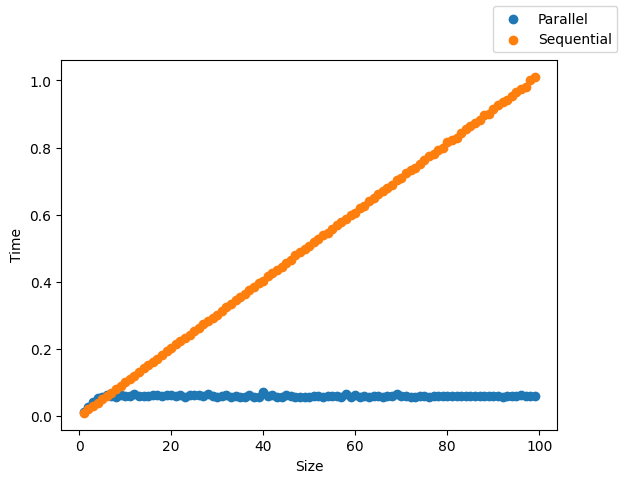

In [213]:


import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes

def plot_times(ax: Axes, times: list[dict[str, float]], title: str):
    return ax.scatter(sizes, [list(t.values())[0] for t in times], label=title)



f, ax = plt.subplots(1, 1)
plot_times(ax, res, "Parallel")
plot_times(ax, res1, "Sequential")
h1 = ax.set_xlabel("Size")
h2 = ax.set_ylabel("Time")
f.legend()
f.show()



<figure>
  <img
  src="../../images/process_performance.png"
  height="400px"
  alt="The beautiful MDN logo.">
  <figcaption>Comparison of the runtime (in seconds) of the <i>parallel_work</i> and <i>sequential_work</i> functions as a function of the input size.</figcaption>
</figure>


As you can see from the graph, there is a clear difference in execution time between `sequential_work` and `parallel_work` as the number `n` increases. 
This is due to the fact that if we execute the function `work` sequentially for `n` inputs, we need to wait **at least** `n` times the duration of execution of `work`. 
On the other hand, if we process in parallel, we can cut down the time by maximally `n_proc` where `n_proc` is the number of CPUs our system offers. 
In reality, the speed up will be a bit smaller because of the overhead of starting different processes and the synchronization effort.


<div class="alert alert-block alert-warning">
    <h4><b>Warning</b></h4> In reality, multiprocessing/parallelism in python should be the last resort to improve the performance of your code. 
    You first should try improving your code by using the appropriate algorithms or by adopting numerical libraries like numpy that offer vectorized operations. 
    If this fails, you could try just-in-time compilers like numba, which only require you to add a decorator to existing functions. Only if all these steps yield no improvement should you attempt to use multiprocessing explicitly. 
    If not used carefully, it can even harm the performance of your code.
</div>


### Inter-process communication and data dependencies

The pattern of using `ProcessPoolExecutor` works well for a variety of tasks where we can split the  problem into **independent** unit of works that can be performed at the same time; sometimes these problems are called *embarrassingly parallel*.  
However, many problems in scientific computing contain **data dependencies** where computations depend on the result of other computations. In this case, we cannot simply split our input data across processes as we did before. In these situations, we have a few possible solutions:

1. Split the problem across a dimension where there are no dependencies. 
1. Add communication between processes, so that individual processes can access the result computed by other processes.

In the rest of this section, we will address the second solution, as python offers methods to communicate between processes. The first solution cannot be easily addressed in this course because it requires domain knowledge and  we cannot provide a simple recipe that will work in all cases.

We now consider an example of a problem that can be parallelized but where there are dependencies between the processes: 

0 [9.9998e-01 1.0000e-05 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.00

/tmp/ipykernel_23398/3268562871.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


1 [9.99960001e-01 1.99996000e-05 1.00000000e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.0000

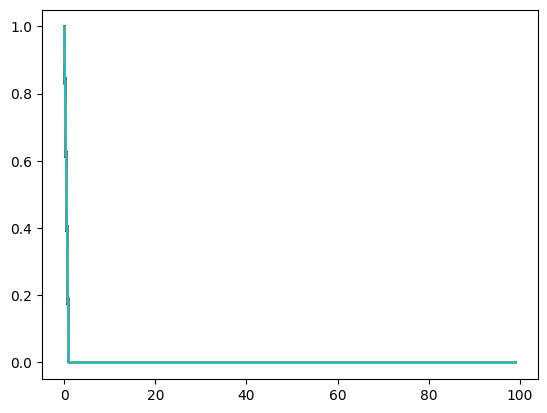

In [212]:
import multiprocessing
import numpy as np

def heat_equation(current, left, right, dt, dx, k):
    alpha = k * dt / dx**2
    return current + alpha * (left - 2*current + right)

def integrate(block, left_temp, right_temp, dt, dx, alpha):
    new_block = np.copy(block)
    for i in range(1, len(block)-1):
        new_block[i] = heat_equation(block[i], block[i-1], block[i+1], dt, dx, alpha)
    new_block[0] = heat_equation(block[0], left_temp, block[1], dt, dx, alpha)
    new_block[-1] = heat_equation(block[-1], block[-2], right_temp, dt, dx, alpha)
    return new_block

def process_block(block_id, block, left_temp, right_temp, dt, dx, alpha, queue):
    new_block = integrate(block, left_temp, right_temp, dt, dx, alpha)
    queue.put((block_id, new_block))

rod = np.zeros(100)
rod[0] = 1  # initial heat source
dt = 0.0001
dx = 0.1
k = 0.001
block_size = 25
queue = multiprocessing.Queue()
n_steps = 100
f, ax = plt.subplots(1, 1)

for _ in range(n_steps):  # 100 time steps
    processes = []
    for i in range(0, len(rod), block_size):
        block = rod[i:i+block_size]
        left_temp = rod[i-1] if i > 0 else 0
        right_temp = rod[i+block_size] if i+block_size < len(rod) else 0
        process = multiprocessing.Process(target=process_block, args=(i//block_size, block, left_temp, right_temp, dt, dx, k, queue))
        processes.append(process)
        process.start()

    for process in processes:
        process.join()
    while not queue.empty():
        block_id, new_block = queue.get()
        rod[block_id*block_size:(block_id+1)*block_size] = new_block
        ax.plot(rod)
        f.show()
    print(_, rod)

In [60]:
import multiprocessing
import numpy as np
from typing import Optional
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

def init_queues(n_blocks: int) -> list[multiprocessing.Queue]:
    queues = [multiprocessing.Queue() for _ in range(n_blocks+1)]
    queues[0].put(0)
    queues[-1].put(0)
    return queues

def get_queues(queues: list[multiprocessing.Queue], block_id: int) -> (Optional[multiprocessing.Queue], Optional[multiprocessing.Queue],):
    left_queue = queues[block_id] if block_id > 0 else None
    right_queue = queues[block_id+1] if block_id < len(queues) - 1 else None
    return left_queue, right_queue

def get_block_index(block_id: int, block_size: int) -> (int, int):
    start = block_id * block_size
    end = start + block_size
    return start, end

def second_derivative(temperatures: ArrayLike, dx: float) -> ArrayLike:
    return (temperatures[2:] - 2*temperatures[1:-1] + temperatures[:-2])/dx**2

def update_temperature(block_id: int, temperatures: ArrayLike, dx: float, dt: float, k, left_queue: Optional[multiprocessing.Queue] , right_queue: Optional[multiprocessing.Queue]):
    start, end = get_block_index(block_id, block_size)
    old_temperatures = temperatures[start:end].copy()
    new_temperatures = np.zeros_like(old_temperatures)
    alpha = k * dt / dx**2
    new_temperatures[1:-1] = old_temperatures[1:-1] +  alpha * second_derivative(old_temperatures, dx)
    if left_queue:
        left_queue.put(new_temperatures[0])
    if right_queue:
        right_queue.put(new_temperatures[-1])
    return new_temperatures
dx = 0.01
dt = 0.01
alpha = 0.01
block_size = 100
n_steps = 1000
n_blocks = 10

temperatures = np.array([0]*block_size*n_blocks)
temperatures[block_size*n_blocks//2] = 100  # initial heat source



def make_animate(ax: Axes, temperatures, dx, dt, alpha, block_size, n_blocks):
    queues = init_queues(n_blocks)
    processes = []
    line, = ax.plot(temperatures)
    for block_id in range(n_blocks):
        left_queue, right_queue = get_queues(queues, block_id)
        process = multiprocessing.Process(target=update_temperature, args=(block_id, temperatures, dx, dt, alpha, left_queue, right_queue))
        processes.append(process)
        process.start()

    def animate(i):
        for block_id in range(n_blocks):
            new_temperatures = queues[block_id].get()  # get new temperatures from the queue
            start, end = get_block_index(block_id, block_size)
            temperatures[start:end] = new_temperatures
            print(i)

        line.set_ydata(temperatures)
        return line,

    return animate
fig, ax = plt.subplots()
af = make_animate(ax, temperatures, dx, dt, alpha, block_size, n_blocks)
ani = FuncAnimation(fig, af , frames=100, interval=2, blit=True)
#ani.save('heat_equation.mpg', writer='ffmpeg', fps=60)


0
0
0
0
0
0
0
0
0
0


In [57]:
HTML(ani.to_jshtml())


KeyboardInterrupt: 

### Threads, GIL and the illusion of concurrency

Thus far, we only discussed one approach to concurrency (and parallelism) in python:  the use of operating system **processes** leveraging the ability of the OS to schedule and coordinate multiple processes across multiple CPUs. 
In reality, there's a second, very similar approach commonly called **threading**. 
Like a **process**, a **thread** is a representation of a task including all needed resources. 
In fact, a process usually consist of multiple threads all sharing a common memory. 
Because of shared memory, a thread is usually lighter in its resource usage than a process, moreover the shared memory means that multiple threads can communicate using shared variables, although this style of concurrency comes with severe performance and safety pitfalls and it is being increasingly discouraged. 
Therefore, in most programming languages we try to achieve concurrency by starting multiple threads in a process.  
However, due to the way the python interpreter is written (the infamous [global interpreter lock](https://wiki.python.org/moin/GlobalInterpreterLock)), we cannot get any performance benefits from running python code across multiple threads: only one thread can perform CPU operations at a time. 
There are however some cases where we could benefit from this style: when we have multiple threads sitting and waiting from input from the network or from some other process. 
This is a case commonly encountered in user interface programming, where we don't want the main user interface to block waiting for the program to fetch data from the network.
In that situation, we can run the GUI in a main thread and have a second thread being responsible for network interaction. 
Here we won't have any speedup but we will give the user the **illusion** of concurrency because the GUI won't freeze while the network threads goes and gets the data.




## Asynchronous programming and couroutines: cooperative multitasking

## Exercises

### Exercise 1: Counting words in a file🌶️🌶️

Write a **parallel** function `count_lines` that counts the number of words in the large file `input_file`

<div class="alert alert-block alert-info">
    <h4><b>Hints</b></h4>
    <ul>
        <li>
            You can open the file <b>read-only</b> multiple times. 
        </li>
        <li>
            Using <code>seek</code> you can specify a line offset from the start of the file. Using <code>read(size)</code> you can read <code>size</code> charcters only. 
        </li>
        <li>
            Write your function in the cell below inside of the <code>solution_exercise1</code> function. The function receives a <code>Path</code> object <code>input_file</code> as an input and should return a single <code>int</code>.
        </li>
    </ul>
<div>


In [11]:
%%ipytest
def solution_exercise1():
    return 42

TestResultOutput(children=(Output(), Box(children=(Output(), Accordion(children=(Output(),), titles=('Click he…

<IPython.core.display.Javascript object>

In [ ]:
%%ipytest
from pathlib import Path
def solution_exercise1(input_file: Path) -> int:
    return 10